<a href="https://colab.research.google.com/github/madarasw/ML_Basics/blob/main/Multiple_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import sys
import matplotlib.pyplot as plt

sys.path.append("drive/MyDrive/Colab Notebooks")
plt.style.use('drive/MyDrive/Colab Notebooks/deeplearning.mplstyle')
os.listdir("drive/MyDrive/Colab Notebooks")

['Test.ipynb',
 'My_Data.csv',
 'Linear_Regression.ipynb',
 'Test2.ipynb',
 'FinRobot.ipynb',
 'DataInterpreter.ipynb',
 'Data Interpreter 2.ipynb',
 'Copy of turicreate-activity-classification.ipynb',
 'Untitled0.ipynb',
 'Untitled1.ipynb',
 'Vectorization.ipynb',
 'Multiple Variable Linear Regression.ipynb',
 'deeplearning.mplstyle',
 '__pycache__',
 'lab_utils_common.py',
 'lab_utils_multi.py',
 'Model_Representation.ipynb',
 'Feature scaling and learning rate.ipynb',
 'lab_utils_uni.py',
 'Cost_function.ipynb',
 'Gradient_Descent.ipynb',
 'Untitled2.ipynb']

Goals:
* Extend our regression model routines to support multiple features
* Extend data structures to support multiple features
* Rewrite prediction, cost and gradient routines to support multiple features
* Utilize NumPy np.dot to vectorize their implementations for speed and simplicity  



In [3]:
import copy, math
import numpy as np
np.set_printoptions(precision=2)  # reduced display precision on numpy arrays

# Problem Statement

You will use the motivating example of housing price prediction. The training dataset contains three examples with four features (size, bedrooms, floors and, age) shown in the table below.  Note that, unlike the earlier labs, size is in sqft rather than 1000 sqft. This causes an issue, which you will solve in the next lab!

| Size (sqft) | Number of Bedrooms  | Number of floors | Age of  Home | Price (1000s dollars)  |   
| ----------------| ------------------- |----------------- |--------------|-------------- |  
| 2104            | 5                   | 1                | 45           | 460           |  
| 1416            | 3                   | 2                | 40           | 232           |  
| 852             | 2                   | 1                | 35           | 178           |  

You will build a linear regression model using these values so you can then predict the price for other houses. For example, a house with 1200 sqft, 3 bedrooms, 1 floor, 40 years old.  

Please run the following code cell to create your `X_train` and `y_train` variables.

In [8]:
x_train = np.array([[2104, 5,1,45],[1416, 3, 2, 40],[852, 2, 1, 35]])
y_train = np.array([460, 232, 178])

## Parameter vector w, b

* $\mathbf{w}$ is a vector with $n$ elements.
  - Each element contains the parameter associated with one feature.
  - in our dataset, n is 4.
  - notionally, we draw this as a column vector

$$\mathbf{w} = \begin{pmatrix}
w_0 \\
w_1 \\
\cdots\\
w_{n-1}
\end{pmatrix}
$$
* $b$ is a scalar parameter.

In [4]:
b_init = 785.1811367994083
w_init = np.array([ 0.39133535, 18.75376741, -53.36032453, -26.42131618])
print(f"w_init shape: {w_init.shape}, b_init type: {type(b_init)}")

w_init shape: (4,), b_init type: <class 'float'>


In [17]:
def predict_single_loop(x, w, b):
  '''
  Predict the price for one selected row of data (one house) with a given w, and b
  Inputs: Features, w, b
  Output: Predicted house price
  '''

  n = x.shape[0]
  predicted_price = 0
  for j in range(n):
    predicted_price += w[j] * x[j]
  total_price = predicted_price + b
  return total_price

In [20]:
# Testing the function

x_vec = x_train[0]
f_wb = predict_single_loop(x_vec, w_init, b_init)

print(f"x_vec shape {x_vec.shape}, x_vec value: {x_vec}")
print(f"prediction: {f_wb}")

x_vec shape (4,), x_vec value: [2104    5    1   45]
prediction: 459.9999976194083


## Single Prediction, vector

Noting that equation (1) above can be implemented using the dot product as in (2) above. We can make use of vector operations to speed up predictions.

Recall from the Python/Numpy lab that NumPy `np.dot()`[[link](https://numpy.org/doc/stable/reference/generated/numpy.dot.html)] can be used to perform a vector dot product.

In [25]:
def predict(x, w, b):
    """
    single predict using linear regression
    Args:
      x (ndarray): Shape (n,) example with multiple features
      w (ndarray): Shape (n,) model parameters
      b (scalar):             model parameter

    Returns:
      p (scalar):  prediction
    """
    p = np.dot(w, x) + b
    return p

In [26]:
# Testing the function

x_vec = x_train[0]
f_wb = predict(x_vec, w_init, b_init)

print(f"x_vec shape {x_vec.shape}, x_vec value: {x_vec}")
print(f"prediction: {f_wb}")

x_vec shape (4,), x_vec value: [2104    5    1   45]
prediction: 459.9999976194083


# 4 Compute Cost With Multiple Variables
The equation for the cost function with multiple variables $J(\mathbf{w},b)$ is:
$$J(\mathbf{w},b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})^2 \tag{3}$$
where:
$$ f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)} + b  \tag{4} $$


In contrast to previous labs, $\mathbf{w}$ and $\mathbf{x}^{(i)}$ are vectors rather than scalars supporting multiple features.

In [128]:
def calculate_cost(x, y, w, b):
    '''
    Compute the cost of the function for a given w and b.
    Args:
      x (ndarray): Shape (n,) example with multiple features
      y (ndarray): Shape (n,) example targets
      w (ndarray): Shape (n,) model parameters
      b (scalar):             model parameter

    Returns:
      p (scalar):  prediction
    '''
    m = x.shape[0]
    cost_sum = 0.0
    for i in range(m):
      f_wb_i = np.dot(x[i], w) + b
      cost_sum += (f_wb_i - y[i])**2
    cost = cost_sum/(2*m)

    return cost

In [129]:
# Compute and display cost using our pre-chosen optimal parameters.
cost = calculate_cost(x_train, y_train, w_init, b_init)
print(f'Cost at optimal w : {cost}')

Cost at optimal w : 1.5578904428966628e-12


In [144]:
def compute_gradient(x, y, w, b):
  '''
    Compute the cost of the function for a given w and b.
    Args:
      x (ndarray): Shape (m,n) example with multiple features
      y (ndarray): Shape (m,) example targets
      w (ndarray): Shape (n,) model parameters
      b (scalar):             model parameter

    Returns:
      p (scalar):  prediction
  '''
  m, n = x.shape
  gradients = np.zeros(4)
  gradient_b = 0.0

  for i in range(m):
    error = (np.dot(x[i], w) + b - y[i])
    for j in range(n):
      gradients[j] += error*x[i][j]
    gradient_b += error

  gradients = gradients/m
  gradient_b = gradient_b/m

  return gradient_b, gradients

In [145]:
#Compute and display gradient
tmp_dj_db, tmp_dj_dw = compute_gradient(x_train, y_train, w_init, b_init)
print(f'dj_db at initial w,b: {tmp_dj_db}')
print(f'dj_dw at initial w,b: {tmp_dj_dw}')

dj_db at initial w,b: -1.6739251501955248e-06
dj_dw at initial w,b: [-2.73e-03 -6.27e-06 -2.22e-06 -6.92e-05]


In [154]:
def gradient_descent(x, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters):
  '''
    Performs batch gradient descent to learn w and b.
    Args:
      x (ndarray):        Shape (m,n) example with multiple features
      y (ndarray):        Shape (m,) example with multiple features
      w_in (ndarray):     Shape (n,) model parameters
      b_in (scalar):      model parameter
      alpha (float):      Learning rate
      cost_function:      function used to calculate the cost
      gradient_function:  function used to calcullate the gradient
      num_iters (int):    number of iterations to run gradient descent

    Returns:
      w (ndarray): Shape (n,) example with multiple features
      b (scalar) : example with multiple features
  '''

  w = w_in
  b = b_in
  m, n = x.shape
  j_history = []


  for iter in range(num_iters):
    gradient_b, gradients = gradient_function(x, y, w_in, b_in)
    for i in range(n):
      w[i] = w[i] - alpha*gradients[i]
    b = b - alpha*gradient_b

    cost = cost_function(x, y, w, b)

    # Save cost J at each iteration
    if iter<100000:      # prevent resource exhaustion
        j_history.append(cost)

    # Print cost every at intervals 10 times or as many iterations if < 10
    if iter% math.ceil(num_iters / 10) == 0:
        print(f"Iteration {iter:4d}: Cost {j_history[-1]:8.2f}")

  return w, b, j_history


In [171]:
# initialize parameters
initial_w = np.zeros_like(w_init)
initial_b = 0.

# some gradient descent settings
iterations = 1000
alpha = 5.0e-9

w_final, b_final, j_history = gradient_descent(x_train, y_train, initial_w, initial_b, calculate_cost, compute_gradient, alpha, iterations)

print(f"Final value for b: {b_final:0.2f}")
print(f"Final value for w: {w_final}")
m,_ = x_train.shape
for i in range(m):
    print(f"prediction: {np.dot(x_train[i], w_final) + b_final:0.2f}, target value: {y_train[i]}")


Iteration    0: Cost 48359.37
Iteration  100: Cost  5012.97
Iteration  200: Cost  1087.87
Iteration  300: Cost   732.44
Iteration  400: Cost   700.24
Iteration  500: Cost   697.32
Iteration  600: Cost   697.04
Iteration  700: Cost   697.01
Iteration  800: Cost   696.99
Iteration  900: Cost   696.98
Final value for b: 0.00
Final value for w: [2.02e-01 4.98e-04 4.86e-05 4.39e-03]
prediction: 425.59, target value: 460
prediction: 286.47, target value: 232
prediction: 172.42, target value: 178


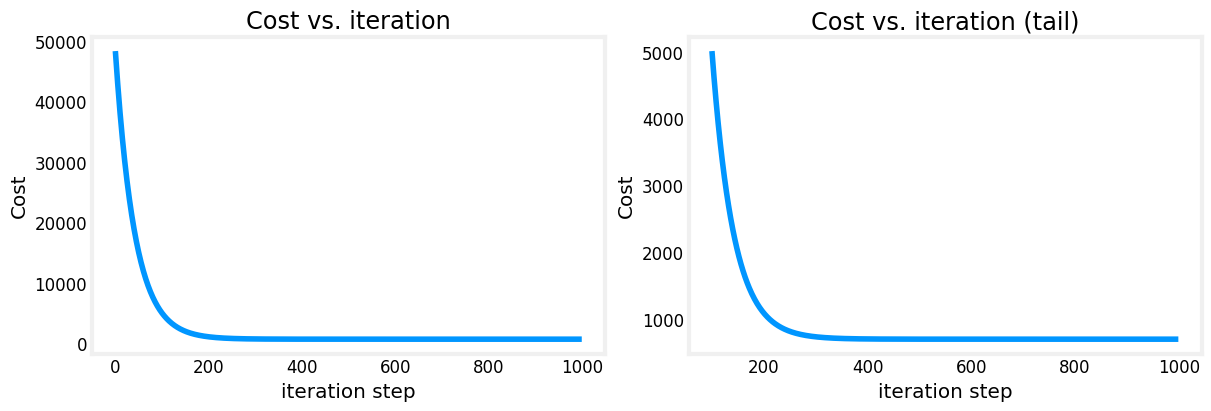

In [176]:
# plot cost versus iteration
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(j_history)
ax2.plot(100 + np.arange(len(j_history[100:])), j_history[100:])
ax1.set_title("Cost vs. iteration");  ax2.set_title("Cost vs. iteration (tail)")
ax1.set_ylabel('Cost')             ;  ax2.set_ylabel('Cost')
ax1.set_xlabel('iteration step')   ;  ax2.set_xlabel('iteration step')
plt.show()